In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os
import sys
import glob

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import multiprocess as mp

import tdgl
import superscreen as sc

# figure_dir = None
figure_dir = "../latex/figures"

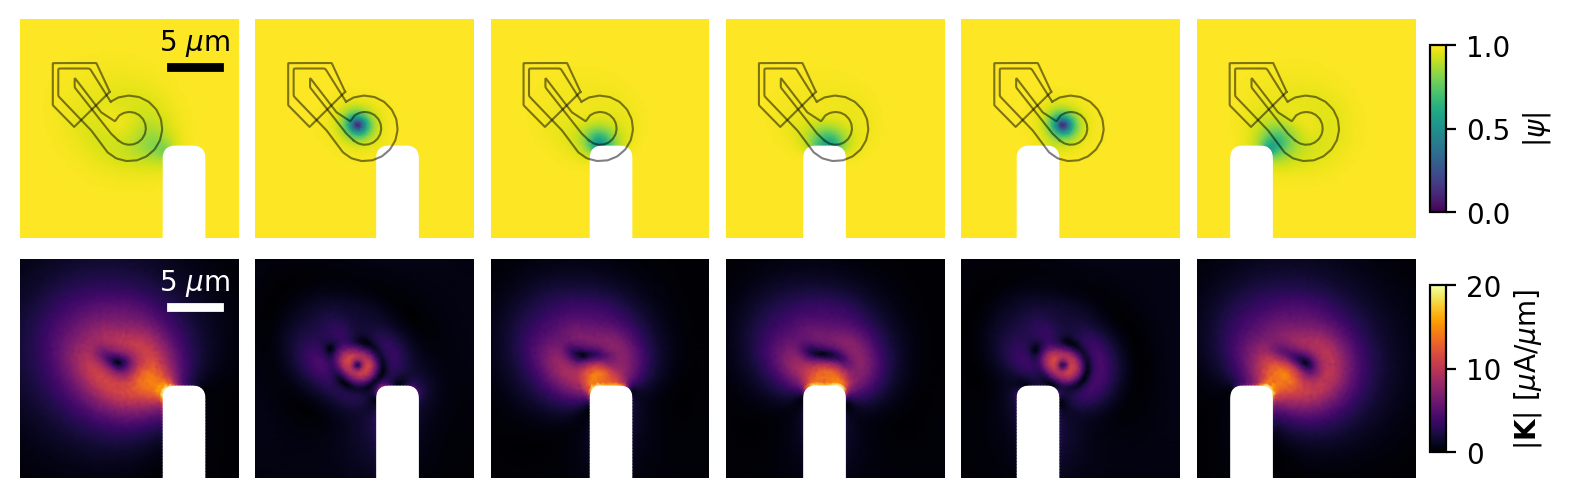

In [2]:
paths = sorted(
    glob.glob("../data/simulation/squid-slot/xy_*_-2/output-0.h5"),
    key=lambda s: float(os.path.dirname(s).split("_")[1])
)

indices = list(range(1, len(paths), 2))

fig, axes = plt.subplots(
    2, len(indices), constrained_layout=True,
    sharex=True, sharey=True, figsize=(7.75, 2.4),
)

for ax in axes.flat:
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
    
squid_solution = None

for path, column in zip(np.array(paths)[indices[::-1]], axes.T):
    dirname = os.path.dirname(path)
    if "results.json" not in os.listdir(dirname):
        continue
    solution = tdgl.Solution.from_hdf5(path)
    psi = solution.tdgl_data.psi
    x, y = solution.device.points.T
    tri = solution.device.triangles
    x0, y0 = list(map(float, os.path.basename(dirname).split("_")[1:]))
    
    if squid_solution is None:
        squid_solution = sc.Solution.from_file(os.path.join(dirname, "squid_solution"))
        
    squid = squid_solution.device
    
    im0 = column[0].tripcolor(
        x, y, tri, np.abs(psi),
        vmin=0, vmax=1,
        shading="gouraud", cmap="viridis",
    )
    K = solution.current_density.to("uA / um").m
    im1 = column[1].tripcolor(
        x, y, tri, np.linalg.norm(K, axis=1),
        vmin=0, vmax=20,
        shading="gouraud", cmap="inferno",
    )

    for name in ["fc", "fc_center", "fc_shield", "pl", "pl_center"][:-2]:
        polygon = squid.polygons[name]
        column[0].plot(*sc.geometry.close_curve(polygon.points).T, "k-", lw=0.75, alpha=0.5)
    
cb_kw = dict(pad=1e-2, shrink=0.75, aspect=10)
cbar0 = fig.colorbar(im0, ax=axes[0], **cb_kw)
cbar0.set_label("$|\\psi|$")
cbar1 = fig.colorbar(im1, ax=axes[1], **cb_kw)
cbar1.set_label("$|\\mathbf{K}|$ [$\\mu$A/$\\mu$m]")
    
for ax in axes[0]:
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
scale = 5
for ax, color in zip(axes[:, 0], "kw"):
    
    scalebar = AnchoredSizeBar(
        ax.transData,
        scale,
        f"{scale} $\\mu$m",
        "upper right",
        color=color,
        pad=0.2,
        size_vertical=0.5,
        label_top=True,
        frameon=False,
        fontproperties=fm.FontProperties(size=10),
    )
    ax.add_artist(scalebar)
    
if figure_dir is not None:
    fig.set_facecolor("white")
    fig.savefig(os.path.join(figure_dir, "squid-slot-top.png"), dpi=300)